## Import Libraries

In [2]:
import os
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
from sklearn.model_selection import train_test_split
import nltk
nltk.download('punkt')
import matplotlib as plt
import seaborn as sns

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


In [3]:
!pip install --upgrade jedi
!pip install --upgrade setuptools

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 57.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 804.0/804.0 kB 44.7 MB/s eta 0:00:00
  Attempting uninstall: setuptools
    Found existing installation: setuptools 67.7.2
    Uninstalling setuptools-67.7.2:
      Successfully uninstalled setuptools-67.7.2


In [4]:
!pip install sentencepiece

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 55.2 MB/s eta 0:00:00


In [5]:
! pip install -Uq git+https://github.com/huggingface/transformers.git
! pip install -Uq git+https://github.com/huggingface/accelerate.git
!pip install -q torch_snippets

import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from torch_snippets import *
from transformers import (T5Tokenizer,T5ForConditionalGeneration)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 268.8/268.8 kB 15.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 70.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 41.8 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 59.4/59.4 kB 7.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 110.5/110.5 kB 14.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 60.0/60.0 kB 8.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 78.6/78.6 kB 10.3 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 202.8/202.8 kB 24.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1

[07/14/23 16:30:15] WARNING  Unable to load torch and dependent libraries from                ]8;id=577525;file:///usr/local/lib/python3.10/dist-packages/torch_snippets/loader.py\loader.py]8;;\:]8;id=809097;file:///usr/local/lib/python3.10/dist-packages/torch_snippets/loader.py#<module>:98\<module>:98]8;;\
                             torch-snippets.                                                                       
                             Functionalities might be limited. pip install lovely-tensors in                       
                             case there are torch related errors                                                   

## Import dataset, Preprocessing, Split

In [6]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [23]:
df = pd.read_csv("/content/drive/MyDrive/Dataset/news-summary/news_summary_more.csv", encoding='latin-1', usecols=['headlines', 'text'])

In [8]:
df.head()

,headlines,text
0,upGrad learner switches to career in ML & Al w...,"Saurav Kant, an alumnus of upGrad and IIIT-B's..."
1,Delhi techie wins free food from Swiggy for on...,Kunal Shah's credit card bill payment platform...
2,New Zealand end Rohit Sharma-led India's 12-ma...,New Zealand defeated India by 8 wickets in the...
3,Aegon life iTerm insurance plan helps customer...,"With Aegon Life iTerm Insurance plan, customer..."
4,"Have known Hirani for yrs, what if MeToo claim...",Speaking about the sexual harassment allegatio...


In [9]:
df.shape

(98401, 2)

In [24]:
# simpleT5 expects dataframe to have 2 columns: "source_text" and "target_text"
df = df.rename(columns={"headlines":"target_text", "text":"source_text"})
df = df[['source_text', 'target_text']]

In [25]:
df.head()

,source_text,target_text
0,"Saurav Kant, an alumnus of upGrad and IIIT-B's...",upGrad learner switches to career in ML & Al w...
1,Kunal Shah's credit card bill payment platform...,Delhi techie wins free food from Swiggy for on...
2,New Zealand defeated India by 8 wickets in the...,New Zealand end Rohit Sharma-led India's 12-ma...
3,"With Aegon Life iTerm Insurance plan, customer...",Aegon life iTerm insurance plan helps customer...
4,Speaking about the sexual harassment allegatio...,"Have known Hirani for yrs, what if MeToo claim..."


<Axes: xlabel='Summary_tokens', ylabel='Count'>

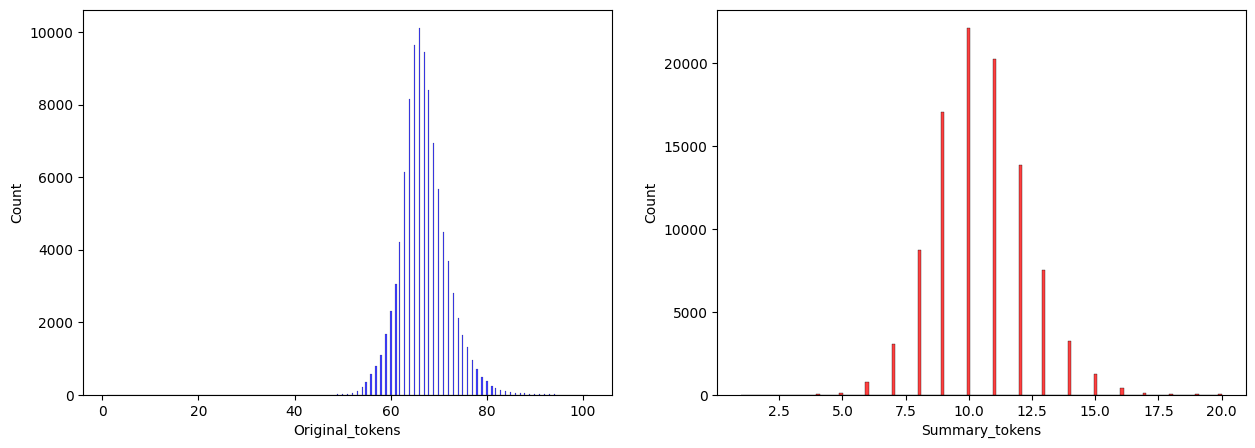

In [12]:
# Assuming 'text' is the column containing the text in your DataFrame
df['Original_tokens'] = df['source_text'].apply(lambda x: len(nltk.word_tokenize(x)))
df['Summary_tokens'] = df['target_text'].apply(lambda x: len(nltk.word_tokenize(x)))

# Plotting the histograms
import matplotlib.pyplot as plt
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(15, 5))
sns.histplot(df['Original_tokens'], ax=axes[0], color='blue')
sns.histplot(df['Summary_tokens'], ax=axes[1], color='red')

In [26]:
# T5 model expects a task related prefix: since it is a summarization task, we will add a prefix "summarize: "
df['source_text'] = "summarize: " + df['source_text']
df.head()

,source_text,target_text
0,"summarize: Saurav Kant, an alumnus of upGrad a...",upGrad learner switches to career in ML & Al w...
1,summarize: Kunal Shah's credit card bill payme...,Delhi techie wins free food from Swiggy for on...
2,summarize: New Zealand defeated India by 8 wic...,New Zealand end Rohit Sharma-led India's 12-ma...
3,summarize: With Aegon Life iTerm Insurance pla...,Aegon life iTerm insurance plan helps customer...
4,summarize: Speaking about the sexual harassmen...,"Have known Hirani for yrs, what if MeToo claim..."


In [40]:
# Splitting the dataset into train and test/validation sets
train_df, test_val_df = train_test_split(df, test_size=0.2, random_state=42)

# Splitting the test/validation set further into test and validation sets
test_df, val_df = train_test_split(test_val_df, test_size=0.5, random_state=42)

# Printing the shape of each dataframe to verify the split
print("Train dataframe shape:", train_df.shape)
print("Test dataframe shape:", test_df.shape)
print("Validation dataframe shape:", val_df.shape)

Train dataframe shape:
(78720, 2)

Test dataframe shape:
(9840, 2)

Validation dataframe shape:
(9841, 2)

In [42]:
train_df = pd.DataFrame(train_df[:20000])
test_df = pd.DataFrame(test_df[:3000])
val_df = pd.DataFrame(val_df[:3000])
# Printing the shape of each dataframe to verify the split


In [43]:
print(type(test_df))

<class 'pandas.core.frame.DataFrame'>

In [44]:
print("Train dataframe shape:", train_df.shape)
print("Test dataframe shape:", test_df.shape)
print("Validation dataframe shape:", val_df.shape)

Train dataframe shape:
(20000, 2)

Test dataframe shape:
(3000, 2)

Validation dataframe shape:
(3000, 2)

## Model architecture

In [32]:
tokenizer = T5Tokenizer.from_pretrained("t5-base")

class ArticleSummaryDataset(Dataset):
    def __init__(self, df, tokenizer):
        self.df = df
        self.tokenizer = tokenizer

    def __len__(self):
        return len(self.df)

    def __getitem__(self, index):

        article = df["source_text"].iloc[index]
        summary = df["target_text"].iloc[index]

        source = self.tokenizer.batch_encode_plus(
            [article],
            add_special_tokens=True,
            max_length=128,
            truncation=True,
            padding='max_length',
            return_attention_mask=True,
            return_tensors="pt"
        )

        target = self.tokenizer.batch_encode_plus(
            [summary],
            add_special_tokens=True,
            max_length=16,
            truncation=True,
            padding='max_length',
            return_attention_mask=True,
            return_tensors="pt"
        )

        article_ids = source['input_ids'].squeeze()
        article_masks = source['attention_mask'].squeeze()
        summary_ids = target['input_ids'].squeeze()
        summary_masks = target['attention_mask'].squeeze()
        return (
            article_ids.to(device, dtype=torch.long),
            article_masks.to(device, dtype=torch.long),
            summary_ids.to(device, dtype=torch.long),
            summary_masks.to(device, dtype=torch.long),
        )

tr_ds = ArticleSummaryDataset(train_df, tokenizer)
val_ds = ArticleSummaryDataset(val_df, tokenizer)

tr_dl = DataLoader(tr_ds, shuffle=True, batch_size=8)
val_dl = DataLoader(val_ds, shuffle=False, batch_size=8)

/usr/local/lib/python3.10/dist-packages/transformers/models/t5/tokenization_t5.py:199: FutureWarning: This tokenizer was incorrectly instantiated with a model max length of 512 which will be corrected in Transformers v5.
For now, this behavior is kept to avoid breaking backwards compatibility when padding/encoding with `truncation is True`.
- Be aware that you SHOULD NOT rely on t5-base automatically truncating your input to 512 when padding/encoding.
- If you want to encode/pad to sequences longer than 512 you can either instantiate this tokenizer with `model_max_length` or pass `max_length` when encoding/padding.
- To avoid this warning, please instantiate this tokenizer with `model_max_length` set to your preferred value.
  warnings.warn(


In [33]:
from torch.optim import AdamW
from transformers import AdamW, get_linear_schedule_with_warmup

def train_batch(model, batch, optimizer):
    article_tokens = batch[0].to(device)
    article_masks = batch[1].to(device)
    summary_tokens = batch[2].to(device)
    summary_masks = batch[3].to(device)

    model.train()

    optimizer.zero_grad()

    outputs = model(input_ids=article_tokens,
                   attention_mask=article_masks,
                   labels=summary_tokens,
                   decoder_attention_mask=summary_masks)
    loss, prediction_scores = outputs[:2]

    loss.backward()
    optimizer.step()
    scheduler.step()

    return loss

@torch.no_grad()
def validate_batch(model, batch):
    article_tokens = batch[0].to(device)
    article_masks = batch[1].to(device)
    summary_tokens = batch[2].to(device)
    summary_masks = batch[3].to(device)

    model.eval()

    outputs = model(input_ids=article_tokens,
                   attention_mask=article_masks,
                   labels=summary_tokens,
                   decoder_attention_mask=summary_masks)
    loss, prediction_scores = outputs[:2]
    return loss

num_epochs = 10
model = T5ForConditionalGeneration.from_pretrained("t5-base").to(device)
optimizer = AdamW(model.parameters(), lr=3e-5)
total_steps = len(tr_dl) * num_epochs
scheduler = get_linear_schedule_with_warmup(optimizer,
                                            num_warmup_steps=0,
                                            num_training_steps=total_steps)
log = Report(num_epochs)

output_folder = "outputs"
os.makedirs(output_folder, exist_ok=True)

# train the model
for e in range(num_epochs):
    N = len(tr_dl)
    for i, batch in enumerate(tr_dl):
        loss = train_batch(model, batch, optimizer)
        log.record(e+(i+1)/N, trn_loss=loss, end="\r")

    N = len(val_dl)
    for i, batch in enumerate(val_dl):
        loss = validate_batch(model, batch)
        log.record(e+(i+1)/N, val_loss=loss, end="\r")
    log.report_avgs(e+1)

    # Save the model after each epoch
    epoch_output_folder = os.path.join(output_folder, f"epoch_{e+1}")
    os.makedirs(epoch_output_folder, exist_ok=True)
    model_save_path = os.path.join(epoch_output_folder, "model.pt")
    torch.save(model.state_dict(), model_save_path)

/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:411: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


EPOCH: 1.000  val_loss: 1.157  trn_loss: 1.599  (789.24s - 7103.12s remaining)
EPOCH: 2.000  val_loss: 1.010  trn_loss: 1.257  (1586.49s - 6345.96s remaining)
EPOCH: 3.000  val_loss: 0.910  trn_loss: 1.130  (2412.18s - 5628.42s remaining)
EPOCH: 4.000  val_loss: 0.832  trn_loss: 1.042  (3209.86s - 4814.78s remaining)
EPOCH: 5.000  val_loss: 0.768  trn_loss: 0.977  (4004.87s - 4004.87s remaining)
EPOCH: 6.000  val_loss: 0.773  trn_loss: 0.925  (4801.05s - 3200.70s remaining)
EPOCH: 7.000  val_loss: 0.699  trn_loss: 0.886  (5605.15s - 2402.21s remaining)
EPOCH: 8.000  val_loss: 0.651  trn_loss: 0.856  (6401.43s - 1600.36s remaining)
EPOCH: 9.000  val_loss: 0.655  trn_loss: 0.836  (7197.52s - 799.72s remaining)
EPOCH: 10.000  val_loss: 0.645  trn_loss: 0.821  (8002.86s - 0.00s remaining)


In [34]:
import torch
from transformers import T5ForConditionalGeneration

# Define the path to the saved checkpoint
checkpoint_path = "/content/outputs/epoch_10/model.pt"

# Load the checkpoint and create an instance of T5ForConditionalGeneration
model_state_dict = torch.load(checkpoint_path, map_location=device)
model = T5ForConditionalGeneration.from_pretrained("t5-base")
model.load_state_dict(model_state_dict)

# Move the model to the desired device
model.to(device)


T5ForConditionalGeneration(
  (shared): Embedding(32128, 768)
  (encoder): T5Stack(
    (embed_tokens): Embedding(32128, 768)
    (block): ModuleList(
      (0): T5Block(
        (layer): ModuleList(
          (0): T5LayerSelfAttention(
            (SelfAttention): T5Attention(
              (q): Linear(in_features=768, out_features=768, bias=False)
              (k): Linear(in_features=768, out_features=768, bias=False)
              (v): Linear(in_features=768, out_features=768, bias=False)
              (o): Linear(in_features=768, out_features=768, bias=False)
              (relative_attention_bias): Embedding(32, 12)
            )
            (layer_norm): T5LayerNorm()
            (dropout): Dropout(p=0.1, inplace=False)
          )
          (1): T5LayerFF(
            (DenseReluDense): T5DenseActDense(
              (wi): Linear(in_features=768, out_features=3072, bias=False)
              (wo): Linear(in_features=3072, out_features=768, bias=False)
              (dropout): Dro

## Inference Model

In [35]:
text="""Twitter’s interim resident grievance officer for India has stepped down, leaving the micro-blogging site without a grievance official as mandated by the new IT rules to address complaints from Indian subscribers, according to a source.

The source said that Dharmendra Chatur, who was recently appointed as interim resident grievance officer for India by Twitter, has quit from the post.

The social media company’s website no longer displays his name, as required under Information Technology (Intermediary Guidelines and Digital Media Ethics Code) Rules 2021.

Twitter declined to comment on the development.

The development comes at a time when the micro-blogging platform has been engaged in a tussle with the Indian government over the new social media rules. The government has slammed Twitter for deliberate defiance and failure to comply with the country’s new IT rules.
"""


In [53]:
text = "summarize:" + text
input_tokens = tokenizer.encode(text, return_tensors="pt", truncation=True, max_length=128)
output_tokens = model.generate(input_tokens.to(device), max_length=20, num_return_sequences=1)

# Decode and concatenate the generated summaries for each segment
predictions = []
for tokens in output_tokens:
    summary = tokenizer.decode(tokens, skip_special_tokens=True)
    predictions.append(summary)

final_summary = " ".join(predictions)
print(final_summary)


Twitter's interim resident grievance officer steps down: Source

## Evaluate the model

In [47]:
import locale
locale.getpreferredencoding = lambda: "UTF-8"
!pip install rouge
from rouge import Rouge
rouge = Rouge()


In [45]:
test_df1 = test_df# for 300 predicitons only

# Define a function to generate predictions using the loaded model
def generate_prediction(text):
    input_ids = tokenizer.encode(text, return_tensors="pt", truncation=True, max_length=512)
    outputs = model.generate(input_ids.to(device), max_length=25, min_length=8, num_return_sequences=1)
    predictions = tokenizer.decode(outputs[0], skip_special_tokens=True)
    return predictions

# Apply the generate_prediction function to the 'source_text' column and store the predictions in a new 'predictions' column
test_df1["predictions"] = test_df1['source_text'].apply(generate_prediction)

# Save the DataFrame with predictions to a CSV file
test_df1.to_csv("test_predictions.csv", index=False)

In [48]:

# Convert the columns to lists
hyps = test_df["predictions"].tolist()
refs = test_df["target_text"].tolist()


# Join elements if they are already in a list
hyps = [' '.join(sentences) if isinstance(sentences, list) else sentences for sentences in hyps]
refs = [' '.join(sentences) if isinstance(sentences, list) else sentences for sentences in refs]

# Calculate the Rouge scores
scores = rouge.get_scores(hyps, refs, avg=True)

In [49]:
# Print the ROUGE scores
print(f"ROUGE-1: {scores['rouge-1']['f']:.4f}")
print(f"ROUGE-2: {scores['rouge-2']['f']:.4f}")
print(f"ROUGE-L: {scores['rouge-l']['f']:.4f}")
print(scores)

ROUGE-1: 0.4638

ROUGE-2: 0.2651

ROUGE-L: 0.4426

{
    'rouge-1': {'r': 0.4558469502719494, 'p': 0.4816161764161765, 'f': 0.46376388753617986},
    'rouge-2': {'r': 0.2598793771043767, 'p': 0.27731767491767423, 'f': 0.2650972966475844},
    'rouge-l': {'r': 0.43468975283975103, 'p': 0.46009120694120703, 'f': 0.442598576339721}
}

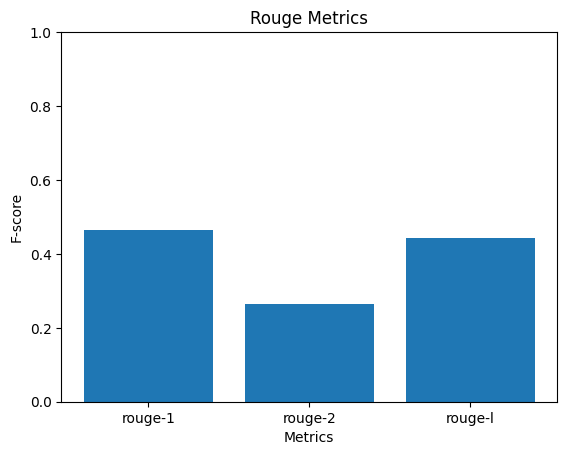

In [50]:
import matplotlib.pyplot as plt
from rouge import Rouge

def plot_rouge_scores(scores):
    metrics = ['rouge-1', 'rouge-2', 'rouge-l']
    scores = [scores['rouge-1']['f'], scores['rouge-2']['f'], scores['rouge-l']['f']]

    plt.bar(metrics, scores)
    plt.ylim([0, 1])  # Set the y-axis limits to ensure consistent scale

    plt.xlabel('Metrics')
    plt.ylabel('F-score')
    plt.title('Rouge Metrics')

    plt.savefig('rouge_metrics.png')
    plt.show()

# Generate the PNG image
plot_rouge_scores(scores)